In [1]:
from Module.MySQL_connector import MySQLConnector
import pandas as pd
import os

In [2]:
sql_connector = MySQLConnector('192.168.31.130', 'bigred', 'bigred', 32010)
query = 'RENAME TABLE first30days_sales_2A TO first30days_sales_aa;'
sql_connector.connectDB('g3_db')
sql_connector.execute_query(query)

Connected to g3_db on 192.168.31.130:32010


OperationalError: (1050, "Table 'first30days_sales_aa' already exists")

In [3]:
def data_fe_pipline(pub_class): 
# import data from MySQL
    sql_connector = MySQLConnector('192.168.31.130', 'bigred', 'bigred', 32010)
    sql_connector.connectDB('g3_db')
    # print(sql_connector.execute_query('show tables;'))
    # sql_connector.execute_query('show tables;')
    main_table = pd.DataFrame(sql_connector.execute_query(f"select * from main_{pub_class}"))
    print('mysql done')
    genres_onehot = pd.DataFrame(sql_connector.execute_query(f"select * from genres_onehot_{pub_class}"))
    features_onehot = pd.DataFrame(sql_connector.execute_query(f"select * from features_onehot_{pub_class}"))
    tags_onehot = pd.DataFrame(sql_connector.execute_query(f"select * from tags_onehot_{pub_class}"))
    id_publisher_aa = pd.DataFrame(sql_connector.execute_query(f"select * from id_publishers_{pub_class}"))
    publishers_info_aa = pd.DataFrame(sql_connector.execute_query(f"select * from publishers_info_{pub_class};"))
    print('mysql done')
    if pub_class == 'aa':
        copiesold = pd.read_csv('../../data/AA/first30days_sales_2A.csv').drop(columns=['timeStamp','releaseDate','days_since_release'])
    elif pub_class == 'aaa':
        copiesold = pd.read_csv('../../data/AAA/first30days_sales_3A.csv').drop(columns=['timeStamp','releaseDate','days_since_release'])
    else:
        copiesold = pd.read_csv('../../data/indie/first30days_sales_indie.csv').drop(columns=['timeStamp','releaseDate','days_since_release'])
    print('mysql done')
    merged_table = pd.merge(main_table, genres_onehot, on='steamId', suffixes=('', '_genres'))
    merged_table = pd.merge(merged_table, tags_onehot, on='steamId', suffixes=('', '_tags'))
    # 再次合併時，處理更多的重複列
    merged_table = pd.merge(merged_table, features_onehot, on='steamId', suffixes=('', '_features'))
    # 找到所有帶有 '_tags' 或 '_features' 後綴的列名
    replicated_columns = [col for col in merged_table.columns if '_tags' in col or '_features' in col]

    # 刪除這些列
    merged_table.drop(columns=replicated_columns, inplace=True)
    cs_pub = pd.merge(copiesold,id_publisher_aa,on="steamId")
    # cs_pub_info = pd.merge(cs_pub, publishers_info_aa, on="steamId")
    cs_pub_info = pd.merge(cs_pub, publishers_info_aa, left_on='publisher', right_on="name").dropna()
    full_table = pd.merge(cs_pub_info, merged_table, on="steamId",suffixes=('', '_pub'))
    columns_to_drop = ['totalRevenue_pub','publisher','name_pub','name','reviews','reviewsSteam','followers','avgPlaytime','reviewScore','releaseDate','firstReleaseDate','copiesSold','revenue','totalRevenue','players','owners','wishlists']
    full_table=full_table.drop(columns=columns_to_drop).dropna()
    return full_table

In [4]:
# 合併時指定 suffixes 參數來處理重複列
full_data_aa = data_fe_pipline('aa')
full_data_aaa = data_fe_pipline('aaa')
full_data_indie = data_fe_pipline('indie').drop_duplicates(subset="steamId", keep='first')
full_data_aa["aa"] = True
full_data_aaa["aaa"] = True
full_data_indie["indie"] = True

Connected to g3_db on 192.168.31.130:32010
mysql done
mysql done
mysql done
Connected to g3_db on 192.168.31.130:32010
mysql done
mysql done
mysql done
Connected to g3_db on 192.168.31.130:32010
mysql done
mysql done
mysql done


In [5]:

full_data = pd.concat([full_data_aaa, full_data_aa,full_data_indie ], ignore_index=True)

In [6]:
full_data_table = full_data_indie.fillna(0)

In [2]:
full_data_table.to_csv("../../data/processed/raw_table_mldl.csv")

NameError: name 'full_data_table' is not defined

In [3]:
full_data_table = pd.read_csv("../../data/processed/raw_table_mldl.csv")

In [4]:
full_data_table

,Unnamed: 0,steamId,sales,averageRevenue,medianRevenue,publishedGames,price,earlyAccess,Accounting,Action,...,Steam Timeline,Steam Trading Cards,Steam Turn Notifications,Steam Workshop,SteamVR Collectibles,Tracked Controller Support,VR Only,VR Supported,Valve Anti-Cheat enabled,indie
0,0,18400,4464.555556,4.679936e+04,32742.0,25,9.99,0,0,0,...,0,1,0,0,0,0,0,0,0,True
1,2,24010,711776.000000,2.374953e+06,6210.0,6,29.99,0,0,0,...,0,1,0,1,0,0,0,0,0,True
2,6,45200,495.433333,1.024300e+04,10243.0,1,4.99,0,0,0,...,0,0,0,0,0,0,0,0,0,True
3,10,45420,38.000000,4.532975e+04,58709.0,4,9.99,0,0,0,...,0,0,0,0,0,0,0,0,0,True
4,12,115800,103633.000000,2.388938e+06,2388938.5,2,19.99,0,0,1,...,0,1,0,0,0,0,0,0,0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17785,38524,3195980,36.000000,1.455342e+02,26.0,73,0.99,0,0,1,...,0,0,0,0,0,0,0,0,0,True
17786,38526,3199400,76.000000,2.875444e+03,468.0,27,2.99,0,0,0,...,0,0,0,0,0,0,0,0,0,True
17787,38528,3207400,1777.000000,4.654333e+03,6158.0,3,3.99,0,0,0,...,0,0,0,0,0,0,0,0,0,True
17788,38530,3211930,15.000000,2.254167e+03,1163.0,30,4.99,0,0,0,...,0,0,0,0,0,0,0,0,0,True


In [1]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# 初始化 MinMaxScaler
scaler = MinMaxScaler()
full_data_table['medianRevenue'] = np.log1p(full_data_table['medianRevenue'])
full_data_table['averageRevenue'] = np.log1p(full_data_table['averageRevenue'])
full_data_table['price'] = np.log1p(full_data_table['price'])
full_data_table['publishedGames'] = np.log1p(full_data_table['publishedGames'])
# 選擇要正規化的欄位
columns_to_scale = ["price", "publishedGames","medianRevenue", "averageRevenue"]
# "medianRevenue", "averageRevenue"
# 對指定欄位進行 Min-Max 轉換
full_data_table[columns_to_scale] = scaler.fit_transform(full_data_table[columns_to_scale])
full_data_table['sales'] = np.log1p(full_data_table['sales'])

# full_table 中的這些欄位現在已經進行 Min-Max 正規化
print(full_data_table["averageRevenue"])

NameError: name 'full_data_table' is not defined

In [79]:
print(full_data_table["averageRevenue"])
full_data_table.to_csv("../../data/processed/full_data_for_ml.csv")

0        0.453316
2        0.762018
6        0.333886
10       0.450807
12       0.762480
           ...   
38524    0.000000
38526    0.234036
38528    0.271885
38530    0.214907
38532    0.222613
Name: averageRevenue, Length: 17790, dtype: float64


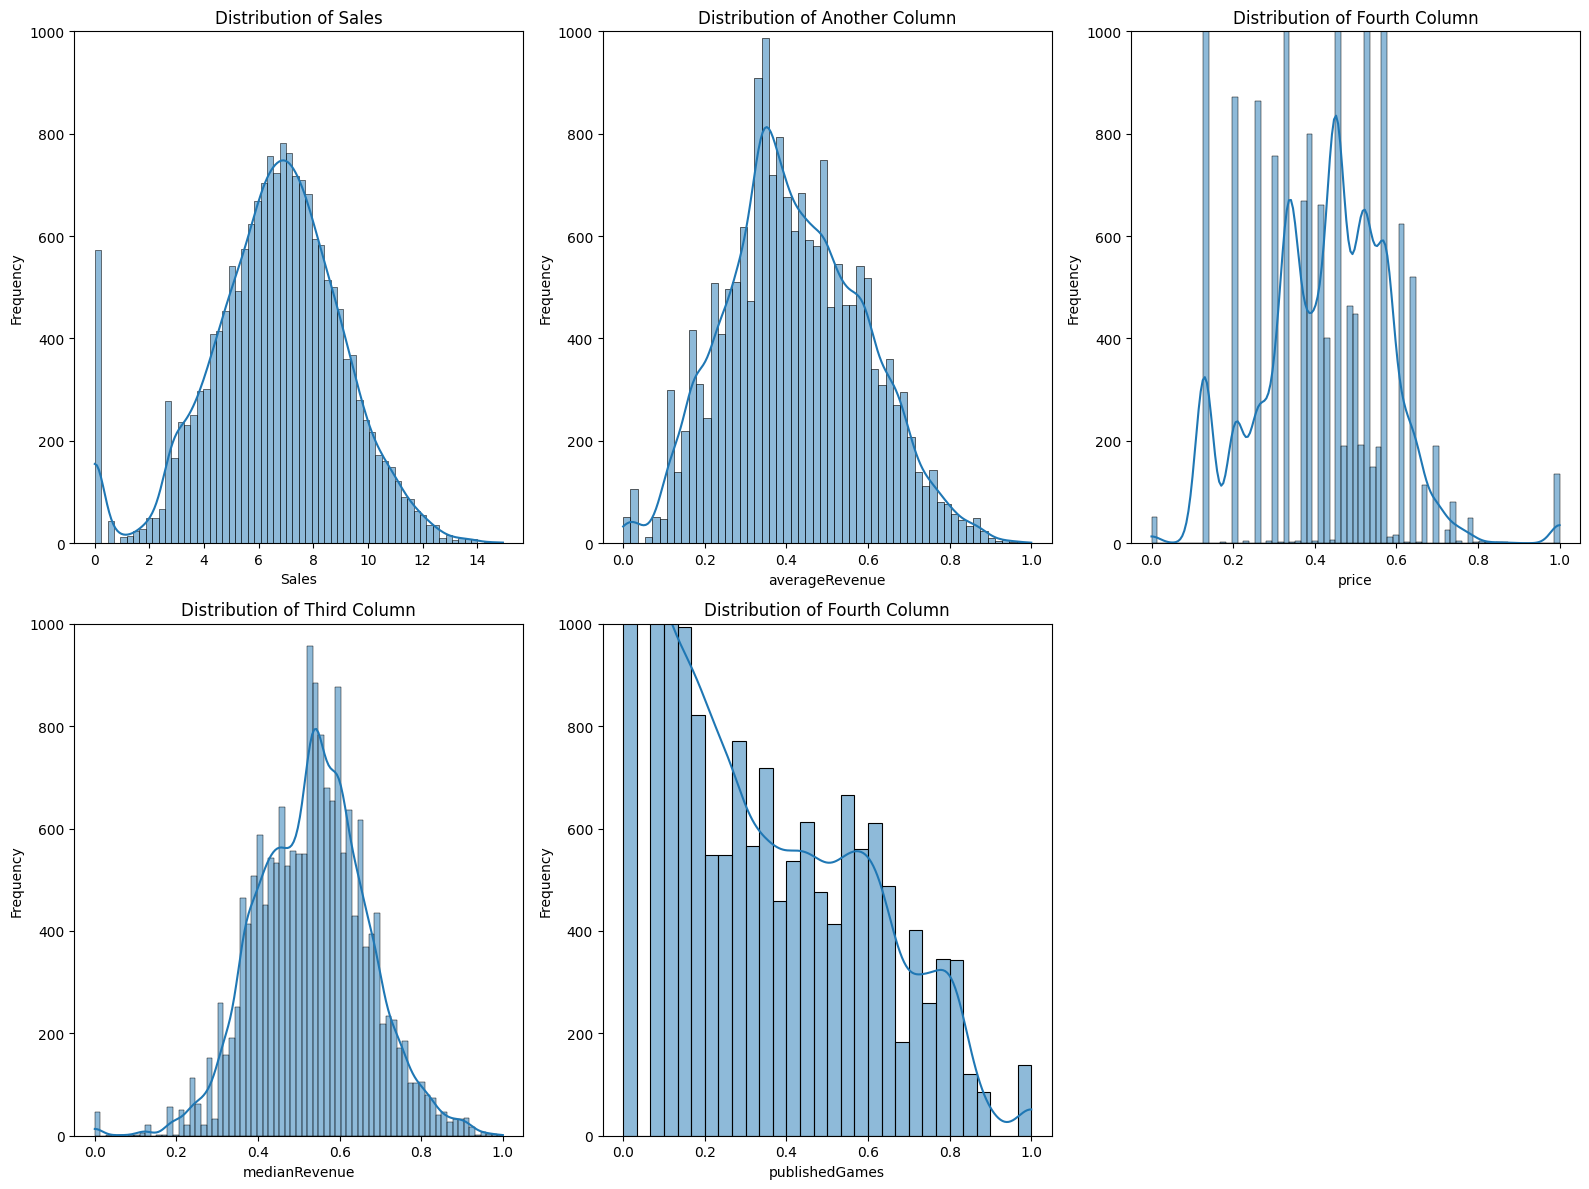

In [78]:
import matplotlib.pyplot as plt
import seaborn as sns

# 創建 2 行 2 列的子圖
fig, axes = plt.subplots(2, 3, figsize=(16, 12))  # 2 rows, 2 columns of subplots

# 第一個子圖 - 繪製 sales 分布
sns.histplot(full_data_table["sales"], kde=True, ax=axes[0, 0])
axes[0, 0].set_title('Distribution of Sales')
axes[0, 0].set_xlabel('Sales')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_ylim(0, 1000)

# 第二個子圖 - 繪製 another_column 分布
sns.histplot(full_data_table["averageRevenue"], kde=True, ax=axes[0, 1])
axes[0, 1].set_title('Distribution of Another Column')
axes[0, 1].set_xlabel('averageRevenue')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_ylim(0, 1000)

# 第三個子圖 - 繪製 third_column 分布
sns.histplot(full_data_table["medianRevenue"], kde=True, ax=axes[1, 0])
axes[1, 0].set_title('Distribution of Third Column')
axes[1, 0].set_xlabel('medianRevenue')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_ylim(0, 1000)

# 第四個子圖 - 繪製 fourth_column 分布
sns.histplot(full_data_table["publishedGames"], kde=True, ax=axes[1, 1])
axes[1, 1].set_title('Distribution of Fourth Column')
axes[1, 1].set_xlabel('publishedGames')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_ylim(0, 1000)

sns.histplot(full_data_table["price"], kde=True, ax=axes[0, 2])
axes[0, 2].set_title('Distribution of Fourth Column')
axes[0, 2].set_xlabel('price')
axes[0, 2].set_ylabel('Frequency')
axes[0, 2].set_ylim(0, 1000)
axes[1, 2].axis('off')  # 不繪製第六個子圖
# 自動調整子圖間距，避免重疊
plt.tight_layout()

# 顯示圖表
plt.show()


In [14]:
import numpy as np
np.log1p(493.27759867694795)


6.2030973

In [18]:
np.expm1(0.2*5.30325516)

1.8882507209621928

In [10]:
pd.read_csv("../../data/processed/raw_table_mldl.csv")

,Unnamed: 0,steamId,sales,averageRevenue,medianRevenue,publishedGames,price,earlyAccess,Accounting,Action,...,Steam Timeline,Steam Trading Cards,Steam Turn Notifications,Steam Workshop,SteamVR Collectibles,Tracked Controller Support,VR Only,VR Supported,Valve Anti-Cheat enabled,indie
0,0,18400,4464.555556,4.679936e+04,32742.0,25,9.99,0,0,0,...,0,1,0,0,0,0,0,0,0,True
1,2,24010,711776.000000,2.374953e+06,6210.0,6,29.99,0,0,0,...,0,1,0,1,0,0,0,0,0,True
2,6,45200,495.433333,1.024300e+04,10243.0,1,4.99,0,0,0,...,0,0,0,0,0,0,0,0,0,True
3,10,45420,38.000000,4.532975e+04,58709.0,4,9.99,0,0,0,...,0,0,0,0,0,0,0,0,0,True
4,12,115800,103633.000000,2.388938e+06,2388938.5,2,19.99,0,0,1,...,0,1,0,0,0,0,0,0,0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17785,38524,3195980,36.000000,1.455342e+02,26.0,73,0.99,0,0,1,...,0,0,0,0,0,0,0,0,0,True
17786,38526,3199400,76.000000,2.875444e+03,468.0,27,2.99,0,0,0,...,0,0,0,0,0,0,0,0,0,True
17787,38528,3207400,1777.000000,4.654333e+03,6158.0,3,3.99,0,0,0,...,0,0,0,0,0,0,0,0,0,True
17788,38530,3211930,15.000000,2.254167e+03,1163.0,30,4.99,0,0,0,...,0,0,0,0,0,0,0,0,0,True
